# Week 3 Part 1 Solutions

_Consider a simple two-body system: A planet of mass $M_p$ and radius $R$, rotating at angular frequency $\Omega$, orbited by a satellite of mass M_s on a keplerian orbit with semi-major axis $a$ and eccentricity $e$. Assume $M_s \ll M_p$._

_1. Write down the equation(s) required to compute the tidal deformation of the planet. Indicate where orbital eccentricity and planetary rotation enter the formulation._

We compute the equilibrium tide height field

    h(ψ,t) = ζ P2(cos ψ) = ζg * 0.5*(3 cos^2 ψ - 1)

on a grid of surface points on a planet, while a satellite orbits in the equatorial
plane. The planet may rotate at angular speed Ω, so the bulge sweeps across the
surface in the body-fixed frame unless Ω matches the satellite's mean motion.

    ζg = G M_s R_p^2 / r_s^3

Here, the time-variable quantity is r_s(t). This makes sense since the tidal deformation should increase at smaller orbital separations. Note though that this equation will break down when R_p is not much smaller than r_s, as this violates the assumption in the taylor expansion in Eqn.  4.7

_2. Implement an algorithm to animate the deformation of the planet’s surface over several orbital periods. Show the behavior of this system with the following parameters:_
   
   a. _$e=0$ and $\Omega=0$_
   
   b. _$e = 0$ and $\Omega=n$_
   
   c. _$e = 0.8$ and $\Omega=3n$_
    
_3. (extra) Implement rotational deformation, assume the rotation is sufficiently small so that the tidal and rotational deformation effects add linearly_


In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import rebound

In [2]:
G = 1.0
m_planet = 1.0
m_sat = 1e-3

a = 1.0
e = 0.2
inc = 0.0

Omega_spin = 1  # try 0.0, 0.3, 1.0, etc.

zeta = 1.0
exaggeration = 1.0   # Exaggeration factor for visualization
zeta_plot = zeta * exaggeration

n_lat = 181
n_lon = 361

In [3]:
sim = rebound.Simulation()
sim.G = G
sim.add(m=m_planet)
sim.add(m=m_sat, a=a, e=e, inc=inc)
sim.move_to_com()

n = np.sqrt(sim.G * (m_planet + m_sat) / a**3)
P_orb = 2*np.pi / n

print(f"Mean motion n = {n:.3f}, orbital period P = {P_orb:.3f}")
print(f"Omega_spin / n = {Omega_spin/n:.3f}")

Mean motion n = 1.000, orbital period P = 6.280
Omega_spin / n = 1.000


In [4]:
lat = np.linspace(-np.pi/2, np.pi/2, n_lat)     # φ
lon = np.linspace(-np.pi, np.pi, n_lon)         # λ
LON, LAT = np.meshgrid(lon, lat)

u0_x = np.cos(LAT) * np.cos(LON)
u0_y = np.cos(LAT) * np.sin(LON)
u0_z = np.sin(LAT)

u0 = np.stack([u0_x, u0_y, u0_z], axis=0)

In [5]:
def equilibrium_tide_height(t):
    """
    Returns h(LAT, LON) at time t for a planet spinning at Omega_spin and a satellite orbiting.
    - Satellite position is taken from REBOUND integration.
    - Surface points are rotated in inertial space by planet spin: lon_inertial = lon + Omega_spin*t.
    """
    sim.integrate(t)
    
    sat = sim.particles[1]
    r_sat = np.array([sat.x, sat.y, sat.z])
    r_norm = np.linalg.norm(r_sat)
    
    u_sat = r_sat / r_norm

    ang = Omega_spin * t
    ca, sa = np.cos(ang), np.sin(ang)

    ux = ca * u0[0] - sa * u0[1]
    uy = sa * u0[0] + ca * u0[1]
    uz = u0[2]
    
    cospsi = ux * u_sat[0] + uy * u_sat[1] + uz * u_sat[2]

    P2 = 0.5 * (3.0 * cospsi**2 - 1.0)

    h = zeta_plot * r_norm**-3 * P2
    return h

def rotational_deformation_height(t):
    """
    Returns h_rot(LAT, LON) for the rotational deformation
    """

    cos_theta = u0[2]
    sin2_theta = 1.0 - cos_theta**2

    h0 = 0.5 * Omega_spin**2 * zeta_plot

    h_rot = h0 * sin2_theta

    return h_rot

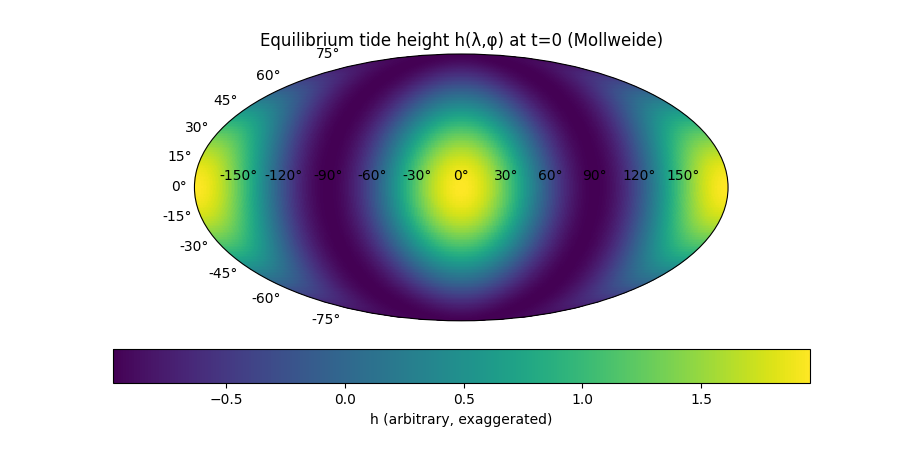

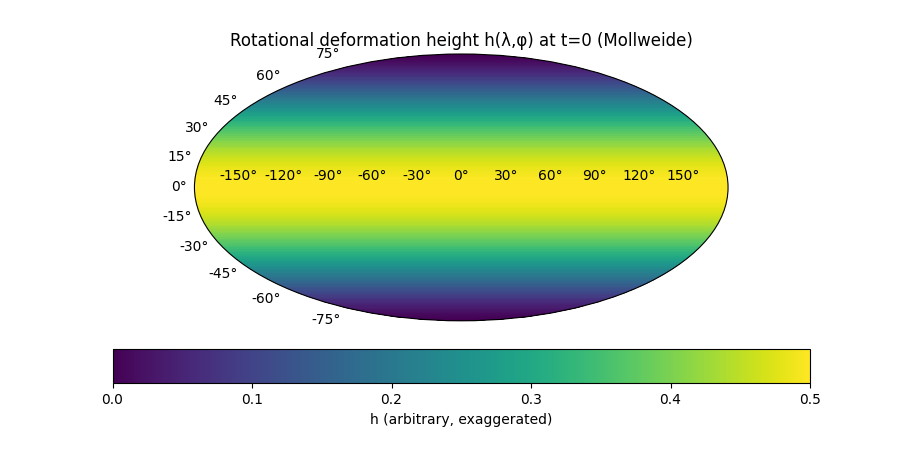

In [6]:
t0 = 0.0

plt.figure(1, figsize=(9, 4.5))
ax = plt.subplot(111, projection="mollweide")
im = ax.pcolormesh(LON, LAT, equilibrium_tide_height(t0), shading="auto")
ax.set_title("Equilibrium tide height h(λ,φ) at t=0 (Mollweide)")
plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.08, label="h (arbitrary, exaggerated)")
plt.show()

plt.figure(2, figsize=(9, 4.5))
ax = plt.subplot(111, projection="mollweide")
im = ax.pcolormesh(LON, LAT, rotational_deformation_height(t0), shading="auto")
ax.set_title("Rotational deformation height h(λ,φ) at t=0 (Mollweide)")
plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.08, label="h (arbitrary, exaggerated)")
plt.show()

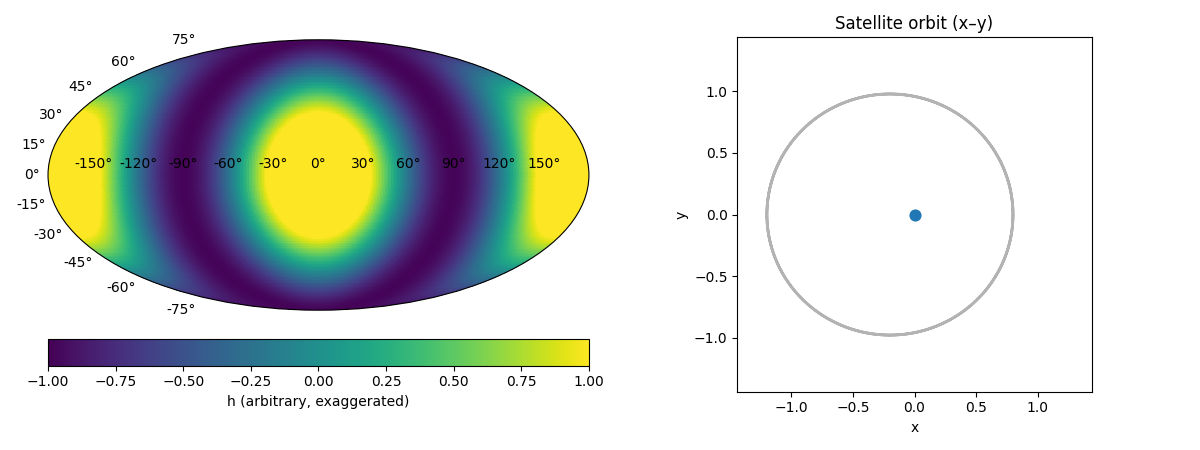

In [7]:
n_frames = 800
times = np.linspace(0, 2*P_orb, n_frames, endpoint=False)

fig = plt.figure(3, figsize=(12, 4.5))

ax_map = fig.add_subplot(1, 2, 1, projection="mollweide")

h_init = equilibrium_tide_height(times[0])
im = ax_map.pcolormesh(LON, LAT, h_init, shading="auto")
cb = plt.colorbar(im, ax=ax_map, orientation="horizontal", pad=0.08, label="h (arbitrary, exaggerated)")
title = ax_map.set_title("")

im.set_clim(-zeta_plot, zeta_plot)

ax_orb = fig.add_subplot(1, 2, 2)
ax_orb.set_aspect("equal", adjustable="box")
ax_orb.set_title("Satellite orbit (x–y)")
ax_orb.set_xlabel("x")
ax_orb.set_ylabel("y")

sim_orb = sim.copy()
orbit_x = np.zeros(n_frames)
orbit_y = np.zeros(n_frames)
for i, t in enumerate(times):
    sim_orb.integrate(t)
    orbit_x[i] = sim_orb.particles[1].x
    orbit_y[i] = sim_orb.particles[1].y

ax_orb.plot(orbit_x, orbit_y, color="0.7", lw=2)
ax_orb.scatter([0.0], [0.0], s=60)

sat_marker, = ax_orb.plot([], [], "o", ms=8)

lim = 1.2 * np.max(np.sqrt(orbit_x**2 + orbit_y**2))
ax_orb.set_xlim(-lim, lim)
ax_orb.set_ylim(-lim, lim)

def update(frame_idx):
    t = times[frame_idx]

    h = equilibrium_tide_height(t)
    im.set_array(h.ravel())

    title.set_text(f"Equilibrium tide over surface  |  t = {t:.2f}  (P = {P_orb:.2f})")

    sat = sim.particles[1]
    sat_marker.set_data([sat.x], [sat.y])

    return (im, title, sat_marker)

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=10, blit=False)
plt.tight_layout()
plt.show()
ani.save("./orbit_molliwelde_e"+str(e)+".mp4")

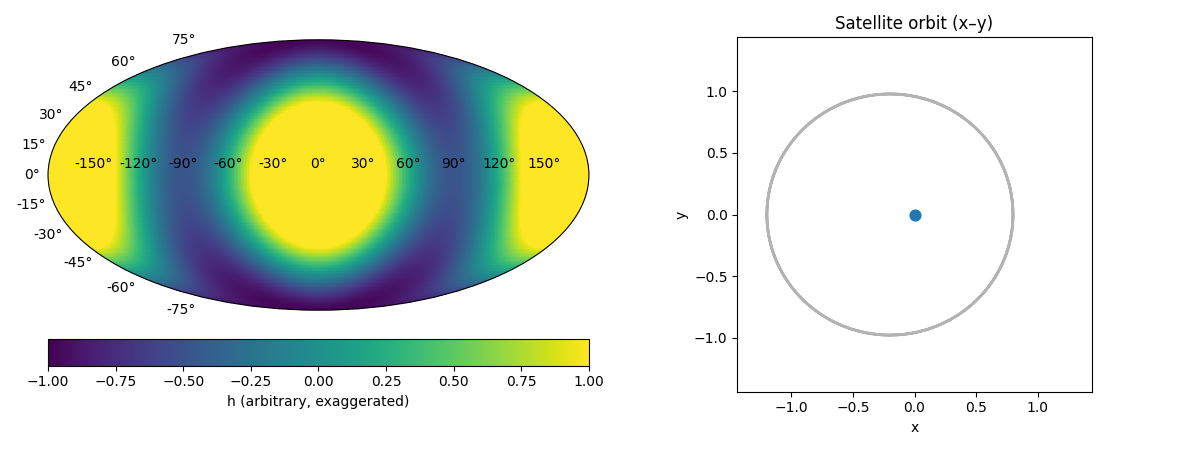

In [8]:
n_frames = 800
times = np.linspace(0, 2*P_orb, n_frames, endpoint=False)

fig = plt.figure(4, figsize=(12, 4.5))

ax_map = fig.add_subplot(1, 2, 1, projection="mollweide")

h_init = equilibrium_tide_height(times[0]) + rotational_deformation_height(times[0])
im = ax_map.pcolormesh(LON, LAT, h_init, shading="auto")
cb = plt.colorbar(im, ax=ax_map, orientation="horizontal", pad=0.08, label="h (arbitrary, exaggerated)")
title = ax_map.set_title("")

im.set_clim(-zeta_plot, zeta_plot)

ax_orb = fig.add_subplot(1, 2, 2)
ax_orb.set_aspect("equal", adjustable="box")
ax_orb.set_title("Satellite orbit (x–y)")
ax_orb.set_xlabel("x")
ax_orb.set_ylabel("y")

sim_orb = sim.copy()
orbit_x = np.zeros(n_frames)
orbit_y = np.zeros(n_frames)
for i, t in enumerate(times):
    sim_orb.integrate(t)
    orbit_x[i] = sim_orb.particles[1].x
    orbit_y[i] = sim_orb.particles[1].y

ax_orb.plot(orbit_x, orbit_y, color="0.7", lw=2)
ax_orb.scatter([0.0], [0.0], s=60)

sat_marker, = ax_orb.plot([], [], "o", ms=8)

lim = 1.2 * np.max(np.sqrt(orbit_x**2 + orbit_y**2))
ax_orb.set_xlim(-lim, lim)
ax_orb.set_ylim(-lim, lim)

def update(frame_idx):
    t = times[frame_idx]

    h = equilibrium_tide_height(t) + rotational_deformation_height(t)
    im.set_array(h.ravel())

    title.set_text(f"Equilibrium tide over surface  |  t = {t:.2f}  (P = {P_orb:.2f})")

    sat = sim.particles[1]
    sat_marker.set_data([sat.x], [sat.y])

    return (im, title, sat_marker)

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=10, blit=False)
plt.tight_layout()
plt.show()
ani.save("./orbit_molliwelde_e"+str(e)+"_with_rot.mp4")